In [1]:
# Import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

# Random seed for reproducibility
seed = 202
np.random.seed(seed)

In [2]:
# Import the train set and test set
train_data = pd.read_csv("train_rodolfo.csv", delimiter=",")
test_data = pd.read_csv("test_rodolfo.csv", delimiter=",")

In [3]:
train_data.Product.value_counts()

0    5378
3    1660
2    1629
1     900
Name: Product, dtype: int64

## If we add the binary columns created during the preprocessing, the score is always 1 (idk why)

In [4]:
#train_data = train_data.drop('DataArpu', axis=1)
train_data = train_data.drop('ID', axis=1)
# Sort the dataset
train_data = train_data.iloc[np.random.permutation(len(train_data))]
train_data = train_data[['DeviceFlag4G', 'DataArpu', 'DataAllowanceContinuous',
       'DeviceFlagSmartphone', 'MonthlyVoiceTrafficCount',
       'MonthlySMSTrafficCount', 'MonthlyDataTraffic', 'CustomerGender',
       'CustomerExpatriate', 'ChurnScore', 'AirportConnectionsDuration',
       'AirportConnectionsCount', 'StationConnectionsDuration',
       'StationConnectionsCount', 'ParkingConnectionsDuration',
       'ParkingConnectionsCount', 'File-Transfer', 'Games',
       'Instant-Messaging-Applications', 'Mail', 'Music-Streaming',
       'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications', 'IsModified', 'CustomerAge', 'Region', 'Province',
       'Product']]
train_data = train_data.reset_index(drop=True)

In [5]:
array = np.asarray(train_data)

# X,Y are the splits between features and labels used to evaluate SelectKBest
X = array[:,0:train_data.shape[1]-1]
X = np.asarray(X)
Y = array[:,train_data.shape[1]-1]
Y = np.asarray(Y)

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
chi2_test = SelectKBest(score_func=chi2, k=29)
fit = chi2_test.fit(X,Y)

In [7]:
train_data.columns[chi2_test.get_support(indices=True)]

Index(['DeviceFlag4G', 'DataArpu', 'DataAllowanceContinuous',
       'DeviceFlagSmartphone', 'MonthlyVoiceTrafficCount',
       'MonthlyDataTraffic', 'CustomerGender', 'CustomerExpatriate',
       'ChurnScore', 'AirportConnectionsDuration', 'AirportConnectionsCount',
       'StationConnectionsDuration', 'StationConnectionsCount',
       'ParkingConnectionsDuration', 'ParkingConnectionsCount',
       'File-Transfer', 'Instant-Messaging-Applications', 'Mail',
       'Music-Streaming', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified',
       'Web-Applications', 'IsModified', 'CustomerAge', 'Region', 'Province'],
      dtype='object')

In [8]:
def features_labels_split(data):
    
    features = data[train_data.columns[chi2_test.get_support(indices=True)]]
    labels = data['Product']
    return features, labels

In [9]:
def train_test_validation_split(features, labels, val_samples, test_samples):

    features = np.asarray(features)
    labels =np.asarray(labels)
    
    X_test = features[0:test_samples]
    y_test = labels[0:test_samples]

    X_val = features[test_samples:test_samples + val_samples]
    y_val = labels[test_samples:test_samples + val_samples]

    X_train = features[test_samples + val_samples:]
    y_train = labels[test_samples + val_samples:]

    return X_train, X_test, X_val, y_train, y_test, y_val

In [10]:
# train_feat, train_label are the splits of train_data between features and labels
train_feat, train_label = features_labels_split(train_data)

# bin_train_label is the same of train_label but BINARY
bin_train_label = []
 
for i in range(0, len(train_label)):
    if(train_label[i] == 0):
        bin_train_label.append(0)
    else:
        bin_train_label.append(1)
bin_train_label = np.asarray(bin_train_label)
#print(train_label)
#print(bin_train_label)
num_val_samples = 0
num_test_samples = 950

# bin_X_train, bin_X_test, bin_X_val, bin_y_train, bin_y_test, bin_y_val are the splits of train_feat and bin_train_label
bin_X_train, bin_X_test, bin_X_val, bin_y_train, bin_y_test, bin_y_val = train_test_validation_split(train_feat, bin_train_label, num_val_samples, num_test_samples)

XGB: 0.677 (0.019)


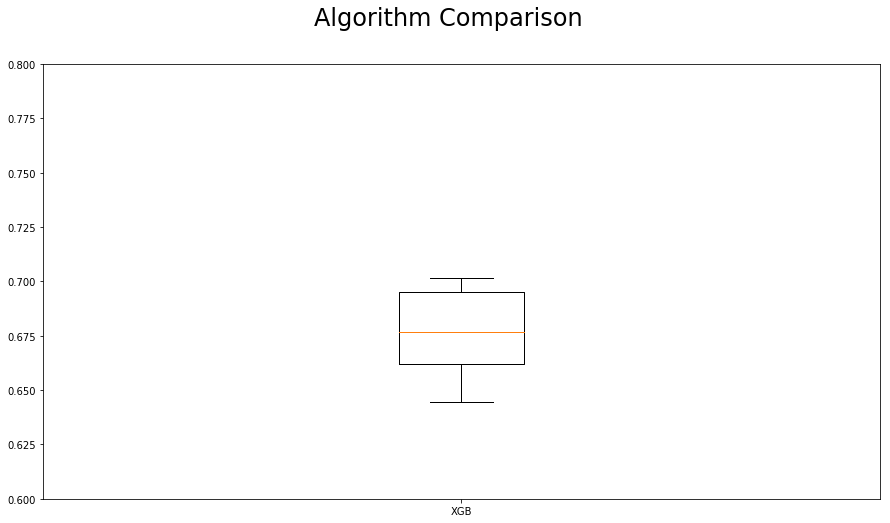

In [11]:
from xgboost import XGBClassifier


xgb = XGBClassifier(n_jobs=-1)

models = []
models.append(('XGB', xgb))




from sklearn.model_selection import cross_val_score

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, bin_X_train, bin_y_train, cv=kfold, scoring='f1', n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison', fontsize=24)
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
plt.ylim([0.60,0.80])
ax.set_xticklabels(names)
plt.show()

In [12]:
# Test Performance

bin_test_model = XGBClassifier(n_jobs=-1)
bin_test_model.fit(bin_X_train, bin_y_train)
bin_y_pred = bin_test_model.predict(bin_X_test)
# F1
print("F1 score on binary unseen data: %.3f" % f1_score(bin_y_test, bin_y_pred))

F1 score on binary unseen data: 0.675


c:\users\eugen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [13]:
# v_train_feat, v_train_label are subsets of train_feat and train_label for which bin_train_label is equal to 1
v_train_feat = train_feat
v_train_label = train_label
count = 0
for i in range(0,len(bin_train_label)):
    if(bin_train_label[i] == 0):
        v_train_feat = v_train_feat.drop(i)
        v_train_label = v_train_label.drop(i)


In [14]:
num_val_samples = 0
num_test_samples = 420
# v_X_train, v_X_test, v_X_val, v_y_train, v_y_test, v_y_valare the splits of v_train_feat and v_train_label
v_X_train, v_X_test, v_X_val, v_y_train, v_y_test, v_y_val = train_test_validation_split(v_train_feat, v_train_label, num_val_samples, num_test_samples)

XGB: 0.416 (0.029)


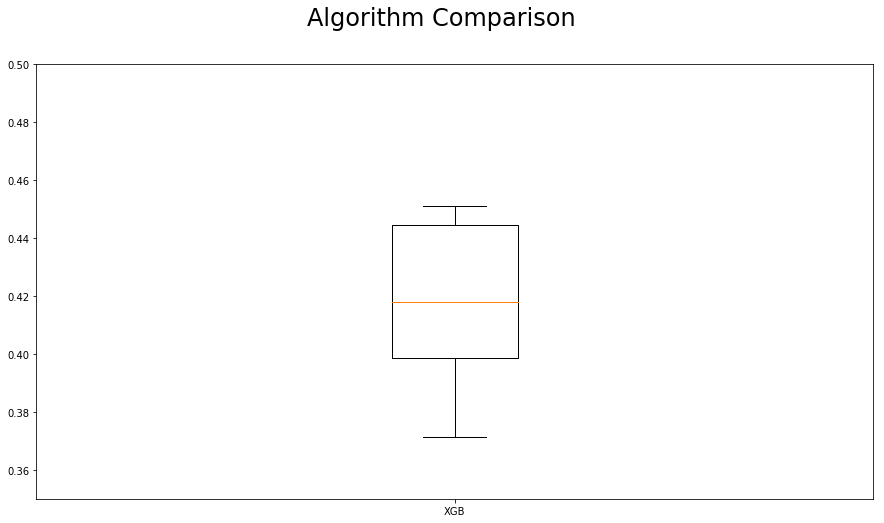

In [15]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, v_X_train, v_y_train, cv=kfold, scoring='f1_micro', n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison', fontsize=24)
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
plt.ylim([0.35,0.50])
ax.set_xticklabels(names)
plt.show()

In [16]:
# Test Performance

v_test_model = XGBClassifier(n_jobs=-1)
v_test_model.fit(v_X_train, v_y_train)
v_y_pred = v_test_model.predict(v_X_test)
# F1
print("F1 score on binary unseen data: %.3f" % f1_score(v_y_test, v_y_pred, average='micro'))

F1 score on binary unseen data: 0.424


c:\users\eugen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [17]:
# bin_X_pred is the data to predict with the same features of train_feat
bin_X_pred = test_data[train_data.columns[chi2_test.get_support(indices=True)]]

In [18]:
bin_classifier = XGBClassifier(n_jobs=-1)
bin_classifier.fit(train_feat, bin_train_label)
# bin_y_pred is the binary prediction for the whole testset
bin_y_pred = bin_classifier.predict(bin_X_pred)

c:\users\eugen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [19]:
submit = test_data['ID']
submit = pd.DataFrame({'ID': submit})

pred = bin_y_pred
pred = pd.DataFrame({'Product': bin_y_pred})

product = []
product = pred.Product
product.shape

(3190,)

In [20]:
# second prediction

In [21]:
# v_X_pred is the data to predict with the same features of train_feat, a subset of bin_X_pred for which bin_y_pred = 1
v_X_pred = bin_X_pred
for i in range(0,len(product)):
    if(pred.values[i] == 0):
        v_X_pred = v_X_pred.drop(i)

In [22]:
v_classifier = XGBClassifier(n_jobs=-1)
v_classifier.fit(v_train_feat, v_train_label)
# v_y_pred is the multiclass prediction for the values of the testset for which it was predicted the label 1 in bin_y_pred
v_y_pred = v_classifier.predict(v_X_pred)

c:\users\eugen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [23]:
v_pred = v_y_pred
v_pred = pd.DataFrame({'Product': v_pred})

v_product = []
v_product = v_pred.Product
v_product.shape

(1211,)

In [24]:
# train_data, test_data are the original datasets (without binary feats)
# ((9567, 41), (3190, 40)) -> ((9567, 34), (3190, 40))
# label MULTICLASS

# X,Y are the splits of train_data between features and labels used to evaluate SelectKBest
# ((9567, 33), (9567,))
# label MULTICLASS

# train_feat, train_label are the splits of train_data between features and labels
# (9567, 29), (9567,)
# label MULTICLASS

# bin_train_label is the same of train_label but BINARY
# (9567,)
# label BINARY

# bin_X_train, bin_X_test, bin_X_val, bin_y_train, bin_y_test, bin_y_val are the splits of train_feat and bin_train_label
# (8617, 29), (950, 29), (0, 29), (8617,), (950,), (0,)
# label BINARY

# v_train_feat, v_train_label are subsets of train_feat and train_label for which bin_train_label is equal to 1
# (4189, 29), (4189,)
# label MULTICLASS

# v_X_train, v_X_test, v_X_val, v_y_train, v_y_test, v_y_valare the splits of v_train_feat and v_train_label
# (3769, 29), (420, 29), (0, 29), (3769,), (420,), (0,)
# label MULTICLASS

# bin_X_pred is the data to predict with the same features of train_feat
# (3190, 29)

# bin_y_pred is the binary prediction for the whole testset
# (3190,)
# label BINARY

# v_X_pred is the data to predict with the same features of train_feat, a subset of bin_X_pred for which bin_y_pred = 1
# (1239, 29)

# v_y_pred is the multiclass prediction for the values of the testset for which it was predicted the label 1 in bin_y_pred
# (1239,)
# label MULTICLASS

In [25]:
bin_y_pred.shape,pd.DataFrame({'wewe':v_y_pred}).describe()
bin_y_pred,v_y_pred

(array([1, 0, 1, ..., 0, 0, 0]), array([2, 2, 2, ..., 2, 3, 2], dtype=int64))

In [26]:
binypred = bin_y_pred
pred = []
vypred = v_y_pred
ct = 0

for i in range(0,len(bin_y_pred)):
    if(bin_y_pred[i] == 1):
        pred.append(v_y_pred[ct])
        ct += 1
    else:
        pred.append(0)
        
        


In [27]:
for i in range(len(pred)):
    print(str(pred[i]) + " / " + str(bin_y_pred[i]))

2 / 1
0 / 0
2 / 1
2 / 1
3 / 1
2 / 1
2 / 1
0 / 0
0 / 0
3 / 1
0 / 0
0 / 0
2 / 1
0 / 0
0 / 0
2 / 1
1 / 1
3 / 1
2 / 1
0 / 0
2 / 1
0 / 0
3 / 1
0 / 0
1 / 1
1 / 1
2 / 1
2 / 1
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
2 / 1
0 / 0
0 / 0
3 / 1
0 / 0
2 / 1
1 / 1
2 / 1
0 / 0
0 / 0
3 / 1
3 / 1
2 / 1
2 / 1
0 / 0
0 / 0
0 / 0
3 / 1
2 / 1
2 / 1
0 / 0
0 / 0
3 / 1
0 / 0
2 / 1
0 / 0
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
2 / 1
0 / 0
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
1 / 1
0 / 0
0 / 0
0 / 0
0 / 0
3 / 1
2 / 1
0 / 0
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
1 / 1
0 / 0
1 / 1
0 / 0
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
3 / 1
0 / 0
0 / 0
2 / 1
0 / 0
0 / 0
1 / 1
3 / 1
3 / 1
3 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
3 / 1
0 / 0
3 / 1
0 / 0
0 / 0
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
3 / 1
3 / 1
0 / 0
0 / 0
3 / 1
0 / 0
0 / 0
2 / 1
0 / 0
3 / 1
3 / 1
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
2 / 1
3 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 

3 / 1
3 / 1
0 / 0
1 / 1
0 / 0
0 / 0
0 / 0
1 / 1
0 / 0
0 / 0
1 / 1
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
3 / 1
0 / 0
0 / 0
0 / 0
0 / 0
3 / 1
0 / 0
1 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
2 / 1
3 / 1
3 / 1
0 / 0
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
3 / 1
2 / 1
0 / 0
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
3 / 1
3 / 1
3 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
2 / 1
3 / 1
0 / 0
2 / 1
3 / 1
3 / 1
0 / 0
0 / 0
0 / 0
0 / 0
2 / 1
3 / 1
0 / 0
0 / 0
2 / 1
0 / 0
0 / 0
1 / 1
0 / 0
0 / 0
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
3 / 1
0 / 0
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
2 / 1
1 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
3 / 1
0 / 0
2 / 1
2 / 1
3 / 1
1 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
3 / 1
2 / 1
2 / 1
0 / 0
0 / 0
3 / 1
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
2 / 1
3 / 1
0 / 0
0 / 0
0 / 0
2 / 1
3 / 1
2 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
3 / 1
0 / 0
0 / 0
0 / 0
2 / 

In [28]:
submit = test_data['ID']
submit = pd.DataFrame({'ID': submit})

pred = np.asarray(pred)
pred = pd.DataFrame({'Product': pred})

product = []
product = pred.Product
product.replace({ 
    int(0) : 'Non-Customer', 
    int(1) : 'V-Bag', 
    int(2) : 'V-Pet', 
    int(3) : 'V-Auto'},
    inplace=True)

submit = submit.join(product)
submit.to_csv('resultaaaaaaaaaaaa.csv', index = False, encoding='utf-8')

In [29]:
submit.Product.describe()

count             3190
unique               4
top       Non-Customer
freq              1979
Name: Product, dtype: object